In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from os.path import dirname, join
import networkx as nx
from itertools import permutations

from graspy.plot import heatmap
from graspy.utils import is_symmetric, symmetrize
from graspy.embed.jrdpg import JointRDPG
from graspy.simulations import sbm, rdpg

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from utils import triu_no_diag, to_distance_mtx, identity, estimate_block_assignment, sort_graph, sbm_params
from simulations import rho_sbm_diff_block, rho_rdpg

In [2]:
def corr_rdpg(n, null):
    X = np.random.uniform(0, 1, (n, 1))
    A = rdpg(X, rescale=False, loops=False)
    if null:
        Y = np.random.uniform(0, 1, (n, 1))
    else:
        Y = np.square(X)
    B = rdpg(Y, rescale=False, loops=False)
    return A, B

In [3]:
def block_permute_vertex(A, block_assignment):
    A = sort_graph(A, block_assignment)
    block_assignment = np.sort(block_assignment)
    _, block_counts = np.unique(block_assignment, return_counts=True)
    shifted_block_counts = np.cumsum(block_counts)

    permuted_idx = []
    for i, count in enumerate(block_counts):
        idx = np.arange(count)
        np.random.shuffle(idx)
        if i >= 1:
            idx += shifted_block_counts[i-1]
        permuted_idx.append(idx)
    permuted_idx = np.concatenate(permuted_idx)

    permuted_A = sort_graph(A, permuted_idx)
    return permuted_A

In [12]:
A, B = corr_rdpg(n=100, null=False)

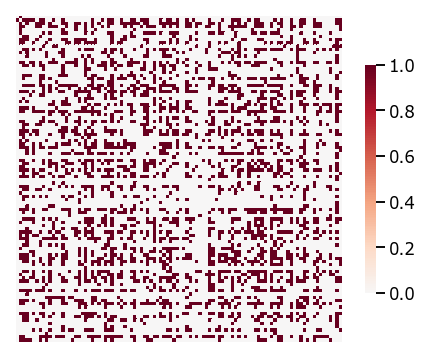

In [13]:
heatmap(A, figsize=(8,6))

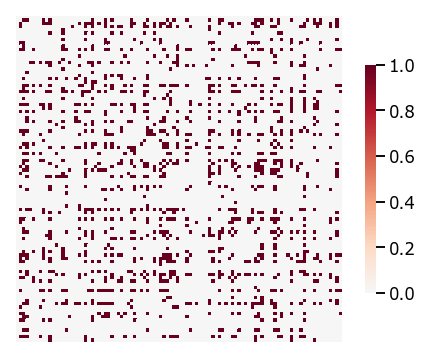

In [14]:
heatmap(B, figsize=(8,6))

In [15]:
block_assignment = estimate_block_assignment(A, B, k=A.shape[0]//2, num_repeats=10)

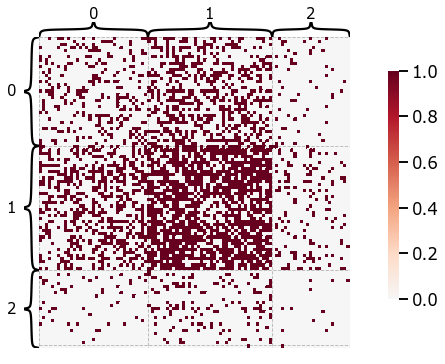

In [16]:
heatmap(A, inner_hier_labels=block_assignment, figsize=(8,6))

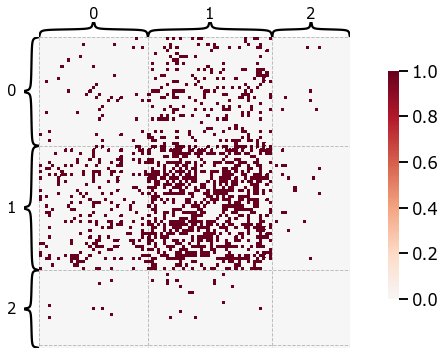

In [17]:
heatmap(B, inner_hier_labels=block_assignment, figsize=(8,6))

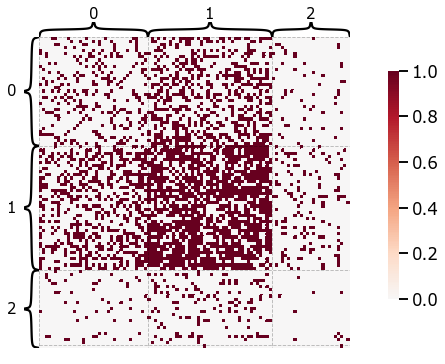

In [18]:
heatmap(block_permute_vertex(A, block_assignment), inner_hier_labels=np.sort(block_assignment), figsize=(8,6))

In [19]:
A, B = corr_rdpg(n=100, null=True)

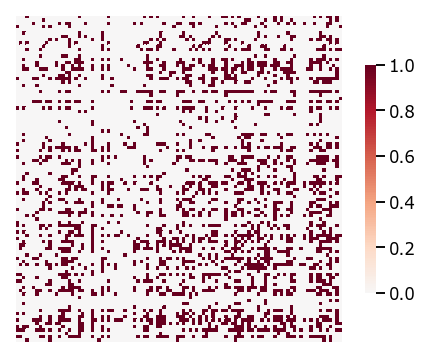

In [20]:
heatmap(A, figsize=(8,6))

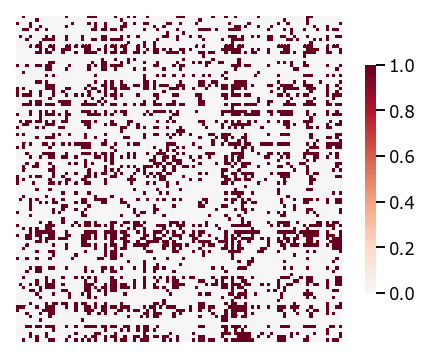

In [21]:
heatmap(B, figsize=(8,6))

In [22]:
block_assignment = estimate_block_assignment(A, B, k=A.shape[0]//2, num_repeats=10)

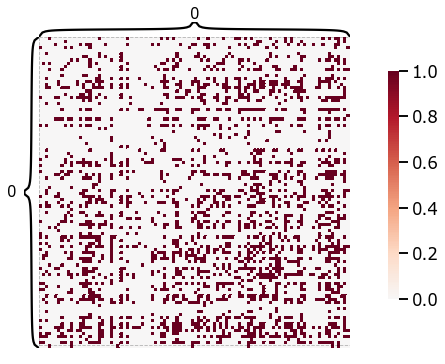

In [23]:
heatmap(A, inner_hier_labels=block_assignment, figsize=(8,6))

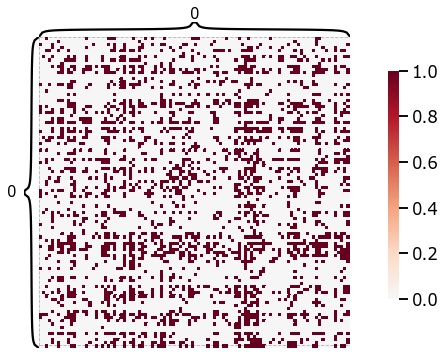

In [24]:
heatmap(B, inner_hier_labels=block_assignment, figsize=(8,6))

In [54]:
A, B = rho_sbm_diff_block(0.3, k=[50, 30, 20], AL=sbm_params(setting='k_block', a=0.9, b=0.4, c=0.1, k=3), 
                          BL=sbm_params(setting='k_block', a=0.8, b=0.3, c=0.1, k=3), n=100)

In [55]:
block_assignment = estimate_block_assignment(A, B, k=3, num_repeats=1)

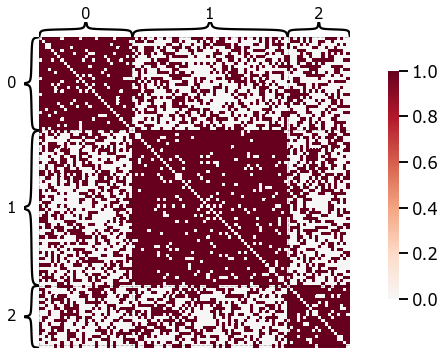

In [56]:
heatmap(A, inner_hier_labels=block_assignment, figsize=(8, 6))

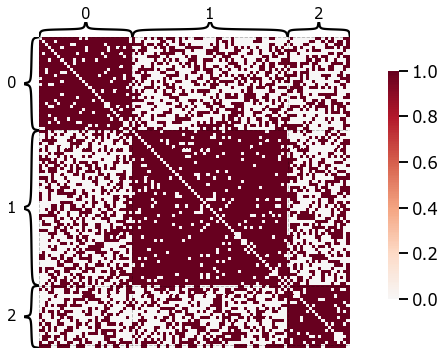

In [60]:
heatmap(block_permute_vertex(A, block_assignment), inner_hier_labels=np.sort(block_assignment), figsize=(8,6))

In [61]:
def rho_sbm_power(indept_test, transform_func, rho, P1, P2, k, n, mc=500, alpha=0.05):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = rho_sbm_diff_block(rho, k, P1, P2, n)
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=transform_func(A), matrix_Y=transform_func(B))
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        block_assignment = estimate_block_assignment(A, B)
        B_sorted = sort_graph(B, block_assignment)
        A_null = block_permute_vertex(A, block_assignment)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B_sorted))
        test_stat_null_array[i] = test_stat_null
    # if pearson, use the absolute value of test statistic then use one-sided
    # rejection region
    if indept_test.get_name() == 'pearson':
        test_stat_null_array = np.absolute(test_stat_null_array)
        test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [66]:
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1])
P1 = sbm_params(setting='k_block', a=0.9, b=0.4, c=0.1, k=3)                    
P2 = sbm_params(setting='k_block', a=0.8, b=0.3, c=0.1, k=3)

test_names = ['pearson', 'dcorr']
power_sbm = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            k = [int(0.5*n), int(0.3*n), n-int(0.5*n)-int(0.3*n)]
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_sbm_power(test, triu_no_diag, rho=rho, P1=P1, P2=P2, k=k, n=n)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=k, n=n)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_sbm_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=k, n=n)
            power_sbm[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)


finish pearson for rho=0.0, n=10
finish pearson for rho=0.0, n=20
finish pearson for rho=0.0, n=30
finish pearson for rho=0.0, n=40
finish pearson for rho=0.0, n=50
finish pearson for rho=0.0, n=60
finish pearson for rho=0.0, n=70
finish pearson for rho=0.0, n=80
finish pearson for rho=0.0, n=90
finish pearson for rho=0.0, n=100
finish pearson for rho=0.1, n=10
finish pearson for rho=0.1, n=20
finish pearson for rho=0.1, n=30
finish pearson for rho=0.1, n=40
finish pearson for rho=0.1, n=50
finish pearson for rho=0.1, n=60
finish pearson for rho=0.1, n=70
finish pearson for rho=0.1, n=80
finish pearson for rho=0.1, n=90
finish pearson for rho=0.1, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)


finish dcorr for rho=0.0, n=10
finish dcorr for rho=0.0, n=20
finish dcorr for rho=0.0, n=30
finish dcorr for rho=0.0, n=40
finish dcorr for rho=0.0, n=50
finish dcorr for rho=0.0, n=60
finish dcorr for rho=0.0, n=70
finish dcorr for rho=0.0, n=80
finish dcorr for rho=0.0, n=90
finish dcorr for rho=0.0, n=100
finish dcorr for rho=0.1, n=10
finish dcorr for rho=0.1, n=20
finish dcorr for rho=0.1, n=30
finish dcorr for rho=0.1, n=40
finish dcorr for rho=0.1, n=50
finish dcorr for rho=0.1, n=60
finish dcorr for rho=0.1, n=70
finish dcorr for rho=0.1, n=80
finish dcorr for rho=0.1, n=90
finish dcorr for rho=0.1, n=100


In [67]:
power_sbm

{'pearson': array([[0.034, 0.092, 0.224, 0.254, 0.116, 0.116, 0.104, 0.06 , 0.042,
         0.074],
        [0.054, 0.286, 0.884, 0.96 , 0.982, 0.988, 0.992, 0.998, 1.   ,
         1.   ]]),
 'dcorr': array([[0.05 , 0.12 , 0.274, 0.216, 0.23 , 0.154, 0.07 , 0.108, 0.052,
         0.07 ],
        [0.064, 0.306, 0.814, 0.934, 0.986, 0.988, 0.998, 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}

In [69]:
with open('../results/rho_sbm_permute_vertex_power.pkl', 'wb') as f:
    pickle.dump(power_sbm, f)

In [4]:
def corr_rdpg_power(indept_test, transform_func, n, null, mc=500, alpha=0.05):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    khat = np.zeros(mc)
    for i in tqdm(range(mc)):
        A, B = corr_rdpg(n, null)
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=transform_func(A), matrix_Y=transform_func(B))
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        block_assignment = estimate_block_assignment(A, B, k=A.shape[0]//2, num_repeats=10)
        khat[i] = np.unique(block_assignment).size
        
        B_sorted = sort_graph(B, block_assignment)
        A_null = block_permute_vertex(A, block_assignment)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B_sorted))
        test_stat_null_array[i] = test_stat_null
    # if pearson, use the absolute value of test statistic then use one-sided
    # rejection region
    if indept_test.get_name() == 'pearson':
        test_stat_null_array = np.absolute(test_stat_null_array)
        test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power, khat

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([True, False])
nmc = 500

test_names = ['pearson', 'dcorr']
power_rdpg = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

khat_rdpg = {'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0], nmc)),
       'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0], nmc))}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power, test_khat = corr_rdpg_power(test, triu_no_diag, n=n, null=rho, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power, test_khat = corr_rdpg_power(test, to_distance_mtx, n=n, null=rho, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = corr_rdpg_power(test, to_distance_mtx, n=n)
            power_rdpg[name][i, j] = test_power
            khat_rdpg[name][i, j, :] = test_khat
            print('finish {} for rho={}, n={}'.format(name, rho, n))

In [7]:
power_rdpg

{'pearson': array([[0.012, 0.01 , 0.002, 0.036, 0.022, 0.04 , 0.032, 0.046, 0.006,
         0.032],
        [0.024, 0.026, 0.034, 0.132, 0.396, 0.544, 0.554, 0.   , 0.   ,
         0.   ]]), 'dcorr': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'mgc': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}

In [18]:
np.linspace(10, 200, 20, dtype=int)


array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])

In [2]:
with open('../results/rdpg_power_parallel.pkl', 'rb') as f:
    results = pickle.load(f)

In [8]:
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0.1])
nmc = 500

test_names = ['pearson', 'dcorr']
power_rdpg = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

khat_rdpg = {'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0], nmc)),
       'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0], nmc))}

pearson_power = []
dcorr_power = []

pearson_khat = []
dcorr_khat = []

for i, item in enumerate(results):
    inputs = item[0]
    power = item[1]
    khat = item[2]
    name = inputs[0]
    if name == 'pearson':
        pearson_power.append(power)
        pearson_khat.append(khat)
    elif name == 'dcorr':
        dcorr_power.append(power)
        dcorr_khat.append(khat)

power_rdpg['pearson'] = np.array(pearson_power).reshape(1, 20)
khat_rdpg['pearson'] = np.array(pearson_khat).reshape(1, 20, 500)
power_rdpg['dcorr'] = np.array(dcorr_power).reshape(1, 20)
khat_rdpg['dcorr'] = np.array(dcorr_khat).reshape(1, 20, 500)

In [9]:
power_rdpg

{'pearson': array([[0.002, 0.026, 0.058, 0.178, 0.386, 0.562, 0.624, 0.698, 0.754,
         0.762, 0.002, 0.026, 0.058, 0.178, 0.39 , 0.598, 0.612, 0.652,
         0.712, 0.714]]),
 'dcorr': array([[0.006, 0.03 , 0.02 , 0.088, 0.162, 0.27 , 0.322, 0.362, 0.452,
         0.378, 0.008, 0.03 , 0.024, 0.054, 0.11 , 0.158, 0.284, 0.372,
         0.404, 0.512]]),
 'mgc': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}

In [17]:
np.mean(khat_rdpg['dcorr'][0], axis=1)

array([4.748, 9.168, 9.154, 6.096, 2.748, 2.404, 2.324, 2.268, 2.276,
       2.264, 4.748, 9.156, 8.978, 6.428, 2.87 , 2.43 , 2.282, 2.26 ,
       2.262, 2.28 ])